# Executable Notebook for COG260 Project on Concrete-Abstract Colexification

Data source: https://osf.io/hjvm5/

Paper: https://psyarxiv.com/efs4p/

In [1]:
from scipy.stats import ks_2samp, mannwhitneyu, ttest_ind,  pearsonr, chi2_contingency, spearmanr, f_oneway
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# the library below is useful for estimating the progress of a for loop
# the use of tqdm will be displayed in Demo 2
from tqdm import tqdm

pd.options.mode.chained_assignment = None

Import relevant Python libraries.

In [2]:
df = pd.read_csv("df_all_raw.csv")
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

/var/folders/5b/_w993gdd31x1z6ctz1dyfnsm0000gp/T/ipykernel_3171/2801652837.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_all_raw.csv")


# Data Fields

**clics_form**: the form of the word in the language of interest

**concepticon_id**: unique numerical identifier of underlying concept

**concepticon_gloss**: the concept underlying the word form

**ontological_category**: broad category that the concept falls into

**semantic_field**: a set of words related in meaning

**variety**: the language

**glottocode**: unique alphanumeric identifier for the language variety

**macroarea**: the part of the world the language is common in

**family**: the language family of the current variety

**latitude**: rough latitude where the language variety can be found

**longitude**: rough latitude where the language variety can be found

**age_of_acquisition**: the age at which a concept is typically learned

**concreteness**: a numerical rating of how abstract or concrete a concept is, rated from (100-700)

**familiarity**: a numerical rating of how familiar a concept is to the average person, rated from (100-700)

**imagability**: a numerical rating of how well an average person can mentally visualize a concept, rated from (100-700)

## Setup

First, we will visualize some of the concepticons that we will categorize as either "abstract" or concrete" in tables.

In [3]:
abstract_cpts = df[df['concreteness'] <= 400]
abstract_cpts = abstract_cpts[["concepticon_id", "concepticon_gloss", "concreteness"]].drop_duplicates()
abstract_cpts.sort_values(by="concreteness")

,concepticon_id,concepticon_gloss,concreteness
70619,1461,AT,194.0
12225,1239,HOW,195.0
168102,1157,BECAUSE,196.0
31399,693,FROM,197.0
31491,1459,IF,204.0
...,...,...,...
10693,956,FLEE,400.0
202478,1591,UP,400.0
6894,1593,DEEP,400.0
4819,1456,THROW,400.0


In [4]:
concrete_cpts = df[df['concreteness'] > 400]
concrete_cpts = concrete_cpts[["concepticon_id", "concepticon_gloss", "concreteness"]].drop_duplicates()
concrete_cpts.sort_values(by="concreteness")

,concepticon_id,concepticon_gloss,concreteness
58494,1039,SHOW,402.0
2981,1246,SMALL,402.0
962892,2484,SMALL (NOT TALL),402.0
4973,1086,WORK (ACTIVITY),402.0
16616,1840,BUILD,402.0
...,...,...,...
19090,985,VINEGAR,645.0
8316,496,CUCUMBER,653.0
42870,607,GRASSHOPPER,660.0
18288,986,TOMATO,662.0


To simplify the process of analysis later, we will create dictionaries that map concepticon_id to it's concreteness score and concepticon_gloss

In [5]:
filtered_df = df[["concepticon_id", "concepticon_gloss", "concreteness"]].dropna().drop_duplicates()
id_to_concreteness = filtered_df.set_index("concepticon_id")["concreteness"].to_dict()
id_to_gloss = filtered_df.set_index("concepticon_id")["concepticon_gloss"].to_dict()

## Frequency Histogram for Concreteness of Concepts

To visualise how concreteness is distributed across concepts in the data, we have a histogram:

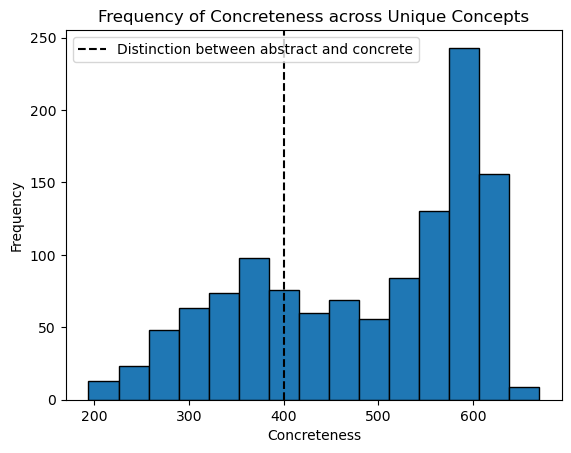

In [6]:
concreteness = filtered_df[["concreteness"]]
plt.hist(concreteness, bins=15,edgecolor="black")
plt.title("Frequency of Concreteness across Unique Concepts")
plt.xlabel("Concreteness")
plt.ylabel("Frequency")
plt.axvline(x=400, ls="--", c="black", label="Distinction between abstract and concrete")
plt.legend()

## Main + Helper functions

In [7]:
def per_lang_colexification(curr_df):
    freq_dict = {}
    conc_combo_dict = {}
    type_count_dict = {"abs_abs": 0, "conc_abs": 0, "conc_conc": 0, "all": 0}
    contigencyList = []
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_id']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:            
            # add to concreteness_comb_dict and type_count_dict
            if combo not in conc_combo_dict:
                if combo[0] in id_to_concreteness and combo[1] in id_to_concreteness:
                    conc1 = id_to_concreteness[combo[0]]
                    conc2 = id_to_concreteness[combo[1]]
                    
                    conc_combo_dict[combo] = (conc1, conc2)
                    
                    type_count_dict["all"] += 1
                    if conc1 > 400 and conc2 > 400:
                        type_count_dict["conc_conc"] += 1
                    elif conc1 <= 400 and conc2 <= 400:
                        type_count_dict["abs_abs"] += 1
                    else:
                        type_count_dict["conc_abs"] += 1
                    
                    
                    # contingency table for chi2 test
                    if (conc1 <= 400 and conc2 <= 400): 
                        contigencyList.append("abs-ab")
                    elif conc1 <= 400 and conc2 > 400: 
                        contigencyList.append("abs-conc")
                    elif conc1 > 400 and conc2 <= 400: 
                        contigencyList.append("conc-abs")
                    elif conc1 > 400 and conc2 > 400: 
                        contigencyList.append("conc-conc")
                        
                    
            # add to freq dict (if it was added to concreteness)
            if combo in freq_dict:
                freq_dict[combo] += 1
            else:
                freq_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp1 = pd.DataFrame(list(conc_combo_dict.items()), columns=['pair_ids', 'concreteness'])
    tmp2 = pd.DataFrame(list(freq_dict.items()), columns=['pair_ids', 'frequency'])
    per_lang = pd.merge(tmp1, tmp2, on='pair_ids', how='inner')
    
    # create dataframe to store percentages of types
    type_counts = pd.DataFrame([type_count_dict])
    
    return per_lang, type_counts, contigencyList

In [8]:
def main():
    all_pairs_dfs = []
    all_type_counts_dfs = []
    all_contigency_list = []
    area_counts = {}
    for area in df['macroarea'].unique():
        area_count_dfs = []
        
        for variety in tqdm(df[df['macroarea'] == area]['variety'].unique()):
            sub = df[df['variety'] == variety]
            agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
            agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
            colex = agg[agg['num_concepts']>1]
            colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
            # We skip any language where no concepts are colexified
            if colex.shape[0] == 0:
                continue
            curr_df, curr_type_count, curr_contingency = per_lang_colexification(colex)
            all_pairs_dfs.append(curr_df)
            all_type_counts_dfs.append(curr_type_count)
            area_count_dfs.append(curr_type_count)
            all_contigency_list.extend(curr_contingency)
        if len(area_count_dfs) > 0:    
            area_df = pd.concat(area_count_dfs)
            area_counts[area] = area_df
    
    #include languages without a given macroarea in the df for all the languages
    for variety in tqdm(df.loc[df['macroarea'].isna(), 'variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df, curr_type_count, curr_contingency = per_lang_colexification(colex)
        all_pairs_dfs.append(curr_df)
        all_type_counts_dfs.append(curr_type_count)
        all_contigency_list.extend(curr_contingency)

    mega = pd.concat(all_pairs_dfs)
    mega_no_freq = mega.copy(deep=True)
    
    mega = mega.groupby(["pair_ids", "concreteness"]).sum().reset_index()
    
    mega_no_freq = mega_no_freq[["pair_ids", "concreteness"]]
    
    all_counts = pd.concat(all_type_counts_dfs)
    
    return mega, mega_no_freq, all_counts, area_counts, Counter(all_contigency_list)

In [9]:
def add_info_cols(df):
    df['x'] = df['concreteness'].apply(lambda coord: coord[0])
    df['y'] = df['concreteness'].apply(lambda coord: coord[1])
    df['pair_glosses'] = df['pair_ids'].apply(lambda ids: (id_to_gloss[ids[0]], id_to_gloss[ids[1]]))
    return df

In [10]:
def get_avg_relative_freqs(df):
    df = df[df['all']!= 0]
    type_percents = pd.DataFrame({
    'Abstract-Abstract': df['abs_abs'] / df['all'] * 100,
    'Concrete-Abstract': df['conc_abs'] / df['all'] * 100,
    'Concrete-Concrete': df['conc_conc'] / df['all'] * 100
    })
    means = type_percents.mean()
    std_devs = type_percents.std()
    return means, std_devs

## Data Processing

In [11]:
mega, mega_no_freq, counts, area_counts, contigencyDict = main()

0it [00:00, ?it/s]
100%|█████████████████████████████████████████| 287/287 [00:11<00:00, 26.05it/s]


In [12]:
mega = add_info_cols(mega)
mega_no_freq = add_info_cols(mega_no_freq)

## Most frequent pairs of each type

In [13]:
abstract_abstract = mega[(mega['x'] <= 400) & (mega['y'] <= 400)]
abstract_abstract.sort_values(by="frequency", ascending=False).head(5)[['pair_glosses', "concreteness", "frequency"]]

,pair_glosses,concreteness,frequency
18584,"(WE (INCLUSIVE), WE)","(270.0, 270.0)",158
12622,"(END (OF SPACE), END (OF TIME))","(320.0, 320.0)",134
23381,"(WITH, AND)","(268.0, 220.0)",132
18549,"(WE (EXCLUSIVE), WE (INCLUSIVE))","(270.0, 270.0)",127
24825,"(THINK (REFLECT), THINK (BELIEVE))","(346.0, 346.0)",125


In [14]:
concrete_concrete = mega[(mega['x'] > 400) & (mega['y'] > 400)]
concrete_concrete.sort_values(by="frequency", ascending=False).head(5)[['pair_glosses', "concreteness", "frequency"]]

,pair_glosses,concreteness,frequency
15406,"(TREE, WOOD)","(604.0, 606.0)",360
22620,"(LEG, FOOT)","(626.0, 558.0)",359
16492,"(WOMAN, WIFE)","(580.0, 562.0)",306
22235,"(HAND, ARM)","(604.0, 592.0)",302
8365,"(LEATHER, SKIN)","(575.0, 614.0)",282


In [15]:
concrete_abstract = mega[((mega['x'] <= 400) & (mega['y'] > 400)) | ((mega['x'] > 400) & (mega['y'] <= 400))]
concrete_abstract.sort_values(by="frequency", ascending=False).head(10)[['pair_glosses', "concreteness", "frequency"]]

,pair_glosses,concreteness,frequency
10785,"(GO, WALK)","(337.0, 452.0)",337
22843,"(MOON, MONTH)","(581.0, 345.0)",332
11324,"(TALL, HIGH)","(439.0, 371.0)",190
11316,"(TALL, LONG)","(439.0, 381.0)",127
21183,"(FEW, SMALL)","(309.0, 402.0)",125
22986,"(CLOCK, HOUR)","(591.0, 375.0)",121
27071,"(HEAVEN, SKY)","(305.0, 542.0)",121
10416,"(EASY, LIGHT (WEIGHT))","(288.0, 550.0)",116
24605,"(HEAR, LISTEN)","(394.0, 408.0)",111
11654,"(SHOUT, CALL)","(471.0, 389.0)",88


## Relative Frequency Bar Graphs

In [16]:
all_means={}

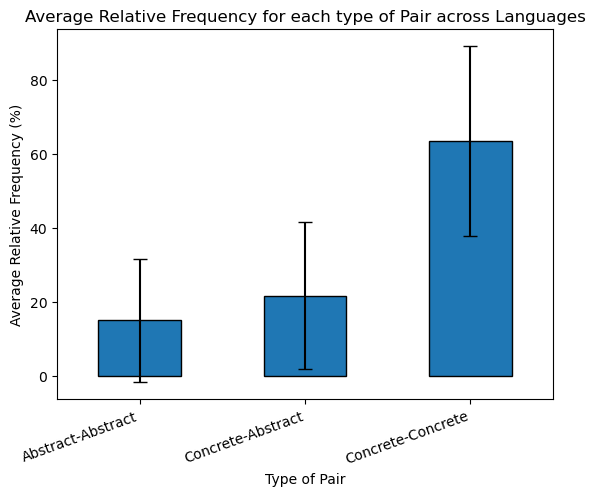

In [17]:
#average relative frequency across all languages

means, std_devs = get_avg_relative_freqs(counts)
all_means['all'] = means
fig, ax = plt.subplots()

means.plot(kind='bar', yerr=std_devs, ax=ax, capsize=5, edgecolor='black')

# Set labels and title
ax.set_ylabel('Average Relative Frequency (%)')
ax.set_xlabel('Type of Pair')
ax.set_title('Average Relative Frequency for each type of Pair across Languages')
plt.xticks(rotation=20, ha="right")

# Show the plot
plt.show()

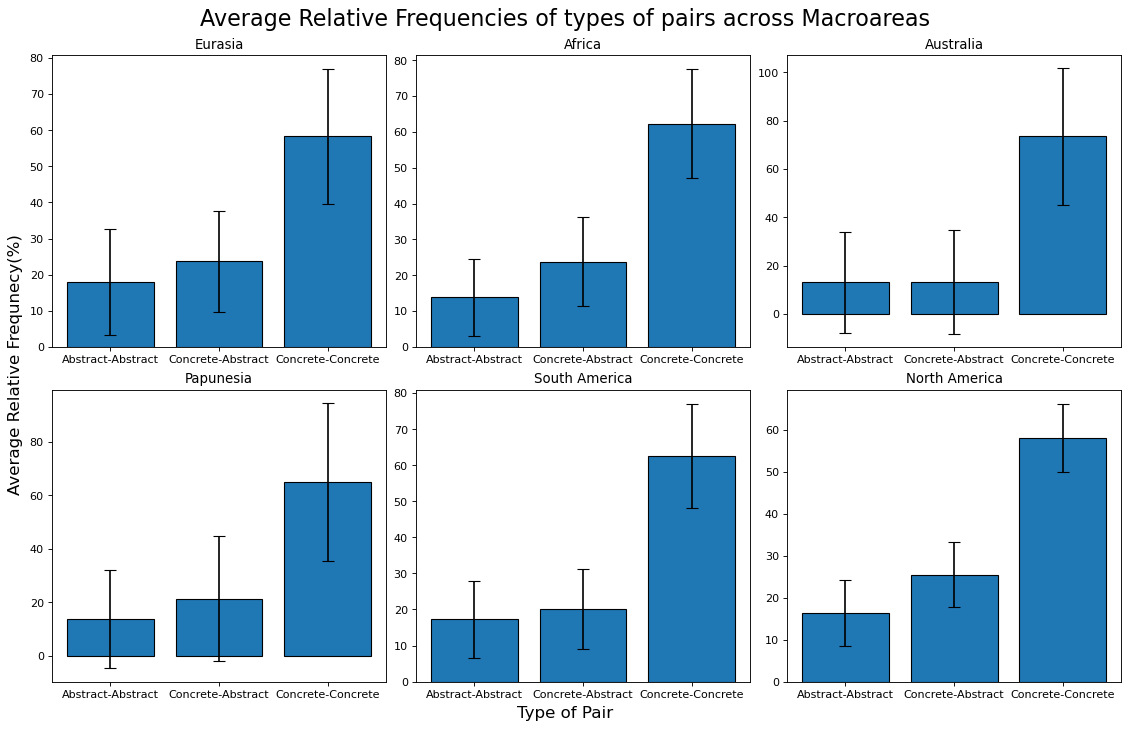

In [18]:
#frequencies across macroareas

fig = plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k', constrained_layout= True)

idx = 1
for macroarea in area_counts.keys():
    means, std_devs = get_avg_relative_freqs(area_counts[macroarea])
    all_means[macroarea] = means
    plt.subplot(2, 3, idx)
    idx += 1
    plt.bar(['Abstract-Abstract', 'Concrete-Abstract', 'Concrete-Concrete'], means, yerr=std_devs, capsize=5, edgecolor='black')
    plt.title(macroarea)

fig.supxlabel("Type of Pair", fontsize=15)
fig.supylabel("Average Relative Frequnecy(%)", fontsize=15)
fig.suptitle("Average Relative Frequencies of types of pairs across Macroareas", fontsize=20)
plt.show()

In [19]:
#exact results
all_means

{'all': Abstract-Abstract    14.929658
 Concrete-Abstract    21.654785
 Concrete-Concrete    63.415557
 dtype: float64,
 'Eurasia': Abstract-Abstract    17.965315
 Concrete-Abstract    23.694759
 Concrete-Concrete    58.339926
 dtype: float64,
 'Africa': Abstract-Abstract    13.874288
 Concrete-Abstract    23.807730
 Concrete-Concrete    62.317983
 dtype: float64,
 'Australia': Abstract-Abstract    13.115146
 Concrete-Abstract    13.401423
 Concrete-Concrete    73.483430
 dtype: float64,
 'Papunesia': Abstract-Abstract    13.749001
 Concrete-Abstract    21.294720
 Concrete-Concrete    64.956280
 dtype: float64,
 'South America': Abstract-Abstract    17.274307
 Concrete-Abstract    20.081000
 Concrete-Concrete    62.644693
 dtype: float64,
 'North America': Abstract-Abstract    16.360889
 Concrete-Abstract    25.508529
 Concrete-Concrete    58.130582
 dtype: float64}

## Density Heat Map

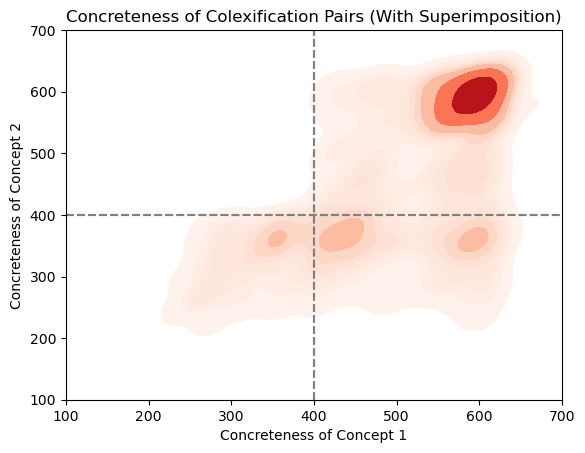

In [20]:
invertAbsConc = []
invertedX = []
invertedY =[]
for i in range(len(mega_no_freq["x"])):
    # I want to translate all ABSTRACT-CONCRETE pairs to CONCRETE-ABSTRACT
    concept1 = mega_no_freq["x"].iloc[i]
    concept2 = mega_no_freq["y"].iloc[i]
    
    if concept1 <= 400 and concept2 > 400:
        newPair = concept2, concept1
        invertAbsConc.append(newPair)
        invertedX.append(concept2)
        invertedY.append(concept1)
    else:
        invertAbsConc.append((concept1, concept2))
        invertedX.append(concept1)
        invertedY.append(concept2)
# Creating a new DataFrame
data = {'invertedAbsConc': invertAbsConc,
        'invertedX': invertedX,
        'invertedY': invertedY}

invertACtoCA = pd.DataFrame(data)
sns.kdeplot(data = invertACtoCA, x="invertedX", y="invertedY", cmap="Reds", fill=True)
plt.xlim(100, 700)
plt.ylim(100, 700)
plt.xlabel('Concreteness of Concept 1')
plt.ylabel('Concreteness of Concept 2')
plt.title('Concreteness of Colexification Pairs (With Superimposition)')
plt.axvline(x=400, ls="--", c="gray")
plt.axhline(y=400, ls="--", c="gray")
plt.axvline(x=400, ls="--", c="gray")
plt.axhline(y=400, ls="--", c="gray")

plt.show()

## Statistical Significance Testing

In [21]:
# TESTING FOR SIGNIFICANT DIFFERENCE IN MACROAREA DISTRIBUTIONS
# Null Hypothesis: There is no difference in the colexification distributions between each macroarea (includes the population as well)
# Creating a new data frame from the macroarea data
dfMacro = pd.DataFrame(all_means)

# Reshaping the data frame to do an ANOVA
dfAnova = dfMacro.melt(var_name='Macroarea', value_name='Average Relative Frequency', ignore_index=False)

# Performing the ANOVA
result_anova = f_oneway(
    dfAnova[dfAnova.index.get_level_values(0) == 'Abstract-Abstract']['Average Relative Frequency'],
    dfAnova[dfAnova.index.get_level_values(0) == 'Abstract-Abstract']['Average Relative Frequency'],
    dfAnova[dfAnova.index.get_level_values(0) == 'Abstract-Abstract']['Average Relative Frequency']
)

# Null Hypothesis Accepted
result_anova


F_onewayResult(statistic=1.9578305050312846e-46, pvalue=1.0)

In [22]:
# Testing for Significant Difference Between Our Abstract and Concrete Concepts Given Our Cut-Off of 400 Using a T-Test
# Null Hypothesis: There is no significance

group1 = abstract_cpts['concreteness']
group2 = concrete_cpts['concreteness']
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

# Null Hypothesis Rejected
# Since the p value is low we can continue knowing that there is a significant difference in concreteness between the two categories given our working definition.
print(f"t-statistic is: {t_stat} ", f"p-value is: {p_value}")

t-statistic is: -65.29396535021377  p-value is: 0.0


In [23]:
# Testing for Linear Relationship Between Our Abstract and Concrete Colexification Using a Pearson Correlation Like in Class
# Null Hypothesis: There is no linear relationship between the two

# Assuming you have two pandas Series or NumPy arrays
x = mega['x']
y = mega['y']
correlation_coefficient, correlation_p_value = pearsonr(x, y)

print(f"Correlation Coefficient is: {correlation_coefficient} ", 
      f"Correlation P- Value is: {correlation_p_value}")

# Null Hypothesis Accepted
# It makes sense that the relationship is non-linear, the p-value is also pretty high

Correlation Coefficient is: 0.21236879179040258  Correlation P- Value is: 1.3070326362478382e-290


In [24]:
# Testing for Independence Between The Category of The First and Second Concreteness Category of The Colexified Pairs Using a Chi2 Test
# Null Hypothesis: the category of the first concepticon gloss in a given colexified pair has no affect (is independent of) the category of the second concepticon gloss in the pair, and vice versa

contingencyTable = [ [ contigencyDict["abs-abs"], contigencyDict["abs-conc"]   ],
                     [ contigencyDict["conc-abs"], contigencyDict["conc-conc"] ]
                    ]               

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingencyTable)

# Display results
print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies: ", expected)
print("Observed Frequencies: ", contingencyTable)

# The results show that there is statistical significance between the expected frequencies of the four categories (given that they are independent) and what was observed from the data. This suggests that there is a relationship between the what concreteness category the first gloss falls into and the second

Chi-square statistic: 2347.0437311228857
P-value: 0.0
Degrees of freedom: 1
Expected frequencies:  [[ 1636.07479435  7456.92520565]
 [ 9234.92520565 42091.07479435]]
Observed Frequencies:  [[0, 9093], [10871, 40455]]


In [25]:
# Testing For Directionality of Relationship Between Concreteness Categorization Within Colexified Pairs Using a Logistic Regression Model
# Null Hypothesis: The odds of the presence of a concrete variable in a colexified pair is not affected by the presence of an abstract concept

# Preparing the data: I need 2 pairs of variable-outcome relationships to do this test
    # Create a binary predictor column based on the 'concreteness' column

mega['predictorAbstract'] = (mega['concreteness'].str[0] <= 400).astype(int)
mega['outcomeConcrete'] = (mega['concreteness'].str[1] > 400).astype(int)

# Define predictors (the first concept being abstract) and target variable (the second concept being concrete)
X = sm.add_constant(mega[['predictorAbstract']])
y = mega['outcomeConcrete']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

# Doing the same steps from above for logistic regression model but with concrete - abstract pairs
mega['predictorConcrete'] = (mega['concreteness'].str[0] > 400).astype(int)
mega['outcomeAbstract'] = (mega['concreteness'].str[1] <= 400).astype(int)

# Define predictors (the first concept being concrete) and target variable (the second concept being abstract)
X = sm.add_constant(mega[['predictorConcrete']])
y = mega['outcomeAbstract']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())


# Null Hypothesis Rejected

Optimization terminated successfully.
         Current function value: 0.638386
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        outcomeConcrete   No. Observations:                28764
Model:                          Logit   Df Residuals:                    28762
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                 0.01635
Time:                        01:38:16   Log-Likelihood:                -18363.
converged:                       True   LL-Null:                       -18668.
Covariance Type:            nonrobust   LLR p-value:                9.598e-135
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8171      0.015     53.392      0.000       0.787       0.847
predicto